In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/miem-hse-ais-2022-lab-04/sample_submission.csv
/kaggle/input/miem-hse-ais-2022-lab-04/test/611.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/7183.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/3845.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/1591.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/3099.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/2646.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/4496.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/3263.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/6700.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/9030.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/364.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/5048.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/5297.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/367.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/5580.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/2750.wav
/kaggle/input/miem-hse-ais-2022-lab-04/test/6728.wav
/kaggle/input/miem-hse-ais-2022-lab-04/te

Получение путей до всех изображений:

In [3]:
import glob

train_files = sorted(glob.glob('../input/miem-hse-ais-2022-lab-04/train/*/*.wav'))
test_files = sorted(glob.glob('../input/miem-hse-ais-2022-lab-04/test/*.wav'))

print('Число тренировочных файлов: {}'.format(len(train_files)))
print('Число тестовых файлов: {}'.format(len(test_files)))

Число тренировочных файлов: 13147
Число тестовых файлов: 9070


Чтение и вывод файла на экран:

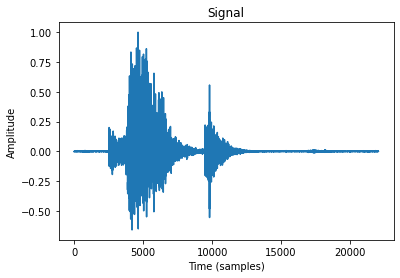

In [4]:
import librosa
from librosa.util import normalize
import matplotlib.pyplot as plt

file_path = train_files[1]
waveform, sr = librosa.load(file_path)
waveform = normalize(waveform)

plt.plot(waveform)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
plt.close()

Создание массивов для датасета:

In [10]:
"""
names = []
words = []    
labels = []  

for path in train_files:
    word = os.path.basename(os.path.dirname(path))  
    name = os.path.basename(path)  
    words.append(word)
    names.append(name)
    labels.append(word)
    
dict_w = {'cat' : 0, 'dog' : 8, 'five' : 5, 'four' : 4, 'house' : 9, 'one' : 1, 'six' : 6, 'stop' : 7, 'three' : 3, 'two' : 2}

for i in range(len(labels)):
    if labels[i] in dict_w:
        labels[i] = dict_w[labels[i]]
""""

Функция преобразования звука в картинку (мелграмму):

In [5]:
from PIL import Image
from librosa.util import normalize

def MelTransform(file_path):
    waveform, sr = librosa.load(file_path)
    waveform = normalize(waveform)
    n_fft = 512
    step = n_fft // 4
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=step)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram = np.round(mel_spectrogram)

    mel_spectrogram = Image.fromarray(mel_spectrogram)
    
    return mel_spectrogram

Функция преобразования звука в картинку (спектограмму):

In [6]:
def SpecTransform(file_path):
    waveform, sr = librosa.load(file_path)
    # waveform = normalize(waveform)
    n_fft = 512
    step = n_fft // 4
    spectrogram = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=step))
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    
    spectrogram = np.round(spectrogram)   #?

    spectrogram = Image.fromarray(spectrogram)
    
    return spectrogram

Функция трансформации изображения:

In [7]:
from torchvision import transforms

transform = transforms.Compose([
            transforms.Resize((200, 200)),
            transforms.ToTensor(),
        ])

Класс датасета для звуковых файлов, передается метод преобразования звука в изображения (method), функция трансформации (transform), директория, где находятся все файлы, список путей ко всем файлам:

In [8]:
from torch.utils.data import Dataset

class DatasetAudio(Dataset):
    
    def __init__(self, dir_path, files_path, method=MelTransform, transform=None):
        self.path = dir_path
        self.names = []
        self.words = []    
        self.labels = []  

        for file in files_path:
            word = os.path.basename(os.path.dirname(file))  
            name = os.path.basename(file)  
            self.words.append(word)
            self.names.append(name)
            self.labels.append(word)

        self.dict_w = {'cat' : 0, 'dog' : 8, 'five' : 5, 'four' : 4, 'house' : 9, 'one' : 1, 'six' : 6, 'stop' : 7, 'three' : 3, 'two' : 2}

        for i in range(len(self.labels)):
            if self.labels[i] in self.dict_w:
                self.labels[i] = self.dict_w[self.labels[i]]
                
        self.transform = transform
        self.method = method
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        audio = self.method(self.path + '/' + self.words[index] + '/' + self.names[index])
        
        if self.transform is not None:
            audio = self.transform(audio)
            
        label = self.labels[index]
            
        return audio, label

Класс датасета для тестовых звуковых файлов, передается метод преобразования звука в изображения (method), функция трансформации (transform), директория, где находятся все файлы, путь к семпл файлу csv:

In [9]:
class DatasetAudioTest(Dataset):
    def __init__(self, file_path, path_words, method=MelTransform, transform=None):
        self.data = pd.read_csv(path_words) 
        self.path = file_path  
        self.transform = transform  
        self.method = method

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        audio = self.method(self.path + '/' + self.data.loc[index, 'id'])

        if self.transform is not None:
            audio = self.transform(audio)

        return audio

Создание датасетов:

In [10]:
from torch.utils.data import random_split

train_dir_path = '../input/miem-hse-ais-2022-lab-04/train'
test_dir_path = '../input/miem-hse-ais-2022-lab-04/test'
test_csv_path = '../input/miem-hse-ais-2022-lab-04/sample_submission.csv'

trainval_dataset = DatasetAudio(train_dir_path, train_files, transform=transform)
train_size = int(0.9 * len(trainval_dataset))
valid_size = len(trainval_dataset) - train_size
train_dataset, valid_dataset = random_split(trainval_dataset, [train_size, valid_size])

test_dataset = DatasetAudioTest(test_dir_path, test_csv_path, transform=transform)

print('Length of train: {}'.format(len(train_dataset)))
print('Length of valid: {}'.format(len(valid_dataset)))
print('Length of test: {}'.format(len(test_dataset)))

for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    print(img.shape, label)
    if i > 10:
        break

Length of train: 11832
Length of valid: 1315
Length of test: 9070
torch.Size([1, 200, 200]) 4
torch.Size([1, 200, 200]) 3
torch.Size([1, 200, 200]) 7
torch.Size([1, 200, 200]) 3
torch.Size([1, 200, 200]) 2
torch.Size([1, 200, 200]) 6
torch.Size([1, 200, 200]) 2
torch.Size([1, 200, 200]) 1
torch.Size([1, 200, 200]) 2
torch.Size([1, 200, 200]) 0
torch.Size([1, 200, 200]) 5
torch.Size([1, 200, 200]) 3


In [11]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models.mobilenet import mobilenet_v2
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, Dataset

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    loss_func = CrossEntropyLoss()
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.repeat(1, 3, 1, 1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test(model, device, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    loss_func = CrossEntropyLoss()
    overall_output = []
    with torch.no_grad():
        for data, target in valid_loader:
            data = data.repeat(1, 3, 1, 1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(valid_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [18]:
batch_size = 10
learning_rate = 0.0001
reduce_lr_gamma = 0.71
epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: {} Epochs: {} Batch size: {}'.format(device, epochs, batch_size))

kwargs = {'batch_size': batch_size}
if torch.cuda.is_available():
    kwargs.update({'num_workers': 1, 'pin_memory': True})
    
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, **kwargs)
valid_loader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, **kwargs)
print('Number of train batches: {} Number of valid batches: {}'.format(len(train_loader), len(valid_loader)))

Device: cpu Epochs: 2 Batch size: 10
Number of train batches: 1184 Number of valid batches: 132


In [16]:
model = mobilenet_v2(pretrained=True)
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=10)
model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer, step_size=1, gamma=reduce_lr_gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, valid_loader)
    scheduler.step()

torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/11832 (0%)]	Loss: 2.100671
Train Epoch: 1 [100/11832 (1%)]	Loss: 2.004104
Train Epoch: 1 [200/11832 (2%)]	Loss: 2.145104
Train Epoch: 1 [300/11832 (3%)]	Loss: 1.810100
Train Epoch: 1 [400/11832 (3%)]	Loss: 1.931698
Train Epoch: 1 [500/11832 (4%)]	Loss: 1.206098
Train Epoch: 1 [600/11832 (5%)]	Loss: 1.081464
Train Epoch: 1 [700/11832 (6%)]	Loss: 1.487223
Train Epoch: 1 [800/11832 (7%)]	Loss: 1.238018
Train Epoch: 1 [900/11832 (8%)]	Loss: 1.066716
Train Epoch: 1 [1000/11832 (8%)]	Loss: 1.220641
Train Epoch: 1 [1100/11832 (9%)]	Loss: 1.026696
Train Epoch: 1 [1200/11832 (10%)]	Loss: 1.177181
Train Epoch: 1 [1300/11832 (11%)]	Loss: 1.106212
Train Epoch: 1 [1400/11832 (12%)]	Loss: 1.082608
Train Epoch: 1 [1500/11832 (13%)]	Loss: 0.896490
Train Epoch: 1 [1600/11832 (14%)]	Loss: 0.751683
Train Epoch: 1 [1700/11832 (14%)]	Loss: 0.529525
Train Epoch: 1 [1800/11832 (15%)]	Loss: 0.392734
Train Epoch: 1 [1900/11832 (16%)]	Loss: 0.701071
Train Epoch: 1 [2000/11832 (17%)]	Loss: 0.63

Предсказание для тренировочных данных:

In [1]:
end_output = []
with torch.no_grad():
    for data in test_loader:
        data = data.repeat(1, 3, 1, 1)
        data = data.to(device)  
        output = model(data) 
        pred = output.argmax(dim=1, keepdim=True)
        end_output += list(pred.cpu().numpy()[:, 0])


NameError: name 'torch' is not defined

Сохранение результата в файл:

In [134]:
dict_w = {0 : 'cat', 8 : 'dog', 5 : 'five', 4 : 'four', 9 : 'house', 1 : 'one', 6 : 'six', 7 : 'stop', 3 : 'three', 2 : 'two'}
for i in range(len(end_output)):
    if end_output[i] in dict_w:
        end_output[i] = dict_w[end_output[i]]

sam_sub = pd.read_csv('../input/miem-hse-ais-2022-lab-04/sample_submission.csv')
submission = pd.DataFrame(sam_sub['id'], columns=['id'])
submission['answer'] = end_output
submission.to_csv('./submission_withnorm200_fft512_0001.csv', index=False)